# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_essay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_esssay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pickle
#please use below code to load glove vectors 
with open('/content/drive/MyDrive/Colab Notebooks/11. GBDT on Donors Chose Dataset/glove_vectors (1)', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [4]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [5]:
import pandas
data = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/9. Decision Trees on DonorsChose/preprocessed_data (2).csv',nrows=35000)
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [6]:
#Analysing Sentiment Scores of Each essay in Project Essays
pos,neg,neu,comp=[],[],[],[] #For appending the 4 categories of sentiment scores
for each_essay in data['essay']:
  sid = SentimentIntensityAnalyzer()
  ss= sid.polarity_scores(each_essay)
  pos.append(ss['pos']) #Positive Sentiment Score
  neg.append(ss['neg']) #Negative Sentiment Score
  neu.append(ss['neu']) #Neutral Sentiment Score
  comp.append(ss['compound']) #Compound Sentiment Score

In [7]:
#Adding all categories of Sentiment Scores as different features to the Data
data['Sentiment_Score_pos']= pos
data['Sentiment_Score_neg']= neg
data['Sentiment_Score_neu']= neu
data['Sentiment_Score_comp']= comp

In [8]:
#Splitting The DataSet into Train and Test
#Split the Dataset into TRAIN and TEST (for Randomized Search CV)
from sklearn.model_selection import train_test_split
train, test = train_test_split(data,test_size=0.33)
train=train.reset_index().drop(['index'], axis=1)
test=test.reset_index().drop(['index'], axis=1)

<h2>1.3 Make Data Model Ready: Encoding Categorical and Numerical Features</h2>

### 1.3.1 Response Coding of Categorical Features


In [9]:
import numpy as np

# A) TRAIN DATA

# 1. School State Train
train['school_state_0']=[0 for j in range(len(train))] #Creating an array of 0s of size len(train) for Probability of Feature Belonging to Class 0 (Creating a new column for feature with probabilities of class 0)
train['school_state_1']=[0 for j in range(len(train))] #Creating an array of 0s of size len(train) for Probability of Feature Belonging to Class 1 (Creating a new column for feature with probabilities of class 1)
uniq_lst=list(train['school_state'].unique()) #List of Unique Categories
for i in range(len(uniq_lst)): #Range of Unique Categories
  total= len(train[(train['school_state']==uniq_lst[i])].index) #Total Number of Occurences of the Category
  one= len(train[(train['school_state']==uniq_lst[i]) & (train['project_is_approved']==1)].index) # Number of Occurences of the Category where it belongs to Class 1
  zero=len(train[(train['school_state']==uniq_lst[i]) & (train['project_is_approved']==0)].index) # Number of Occurences of the Category where it belongs to Class 0
  p=np.round(one/total,3) #Conditional Probability that the Categor belongs to Class 1
  n=np.round(zero/total,3) #Conditional Probability that the Categor belongs to Class 0
  train.loc[train['school_state']==uniq_lst[i],['school_state_0']]=n #Replacing 0s in the array with probability scores of class 0
  train.loc[train['school_state']==uniq_lst[i],['school_state_1']]=p #Replacing 0s in the array with probability scores of class 1


#2. Teacher Prefix Train

train['teacher_prefix_0']=[0 for j in range(len(train))]
train['teacher_prefix_1']=[0 for j in range(len(train))]
uniq_lst_1=list(train['teacher_prefix'].unique())
for i in range(len(uniq_lst_1)):
  total_1= len(train[(train['teacher_prefix']==uniq_lst_1[i])].index)
  one_1= len(train[(train['teacher_prefix']==uniq_lst_1[i]) & (train['project_is_approved']==1)].index)
  zero_1=len(train[(train['teacher_prefix']==uniq_lst_1[i]) & (train['project_is_approved']==0)].index)
  p1=np.round(one_1/total_1,3)
  n1=np.round(zero_1/total_1,3)
  train.loc[train['teacher_prefix']==uniq_lst_1[i],['teacher_prefix_0']]=n1
  train.loc[train['teacher_prefix']==uniq_lst_1[i],['teacher_prefix_1']]=p1


#3. Project Grade Category Train

train['project_grade_category_0']=[0 for j in range(len(train))]
train['project_grade_category_1']=[0 for j in range(len(train))]
uniq_lst_2=list(train['project_grade_category'].unique())
for i in range(len(uniq_lst_2)):
  total_2= len(train[(train['project_grade_category']==uniq_lst_2[i])].index)
  one_2= len(train[(train['project_grade_category']==uniq_lst_2[i]) & (train['project_is_approved']==1)].index)
  zero_2=len(train[(train['project_grade_category']==uniq_lst_2[i]) & (train['project_is_approved']==0)].index)
  p2=np.round(one_2/total_2,3)
  n2=np.round(zero_2/total_2,3)
  train.loc[train['project_grade_category']==uniq_lst_2[i],['project_grade_category_0']]=n2
  train.loc[train['project_grade_category']==uniq_lst_2[i],['project_grade_category_1']]=p2


#4. Clean Categories Train

train['clean_categories_0']=[0 for j in range(len(train))]
train['clean_categories_1']=[0 for j in range(len(train))]
uniq_lst_3=list(train['clean_categories'].unique())
for i in range(len(uniq_lst_3)):
  total_3= len(train[(train['clean_categories']==uniq_lst_3[i])].index)
  one_3= len(train[(train['clean_categories']==uniq_lst_3[i]) & (train['project_is_approved']==1)].index)
  zero_3=len(train[(train['clean_categories']==uniq_lst_3[i]) & (train['project_is_approved']==0)].index)
  p3=np.round(one_3/total_3,3)
  n3=np.round(zero_3/total_3,3)
  train.loc[train['clean_categories']==uniq_lst_3[i],['clean_categories_0']]=n3
  train.loc[train['clean_categories']==uniq_lst_3[i],['clean_categories_1']]=p3

# Clean Sub Categories Train

train['clean_subcategories_0']=[0 for j in range(len(train))]
train['clean_subcategories_1']=[0 for j in range(len(train))]
uniq_lst_4=list(train['clean_subcategories'].unique())
for i in range(len(uniq_lst_3)):
  total_4= len(train[(train['clean_subcategories']==uniq_lst_4[i])].index)
  one_4= len(train[(train['clean_subcategories']==uniq_lst_4[i]) & (train['project_is_approved']==1)].index)
  zero_4=len(train[(train['clean_subcategories']==uniq_lst_4[i]) & (train['project_is_approved']==0)].index)
  p4=np.round(one_4/total_4,3)
  n4=np.round(zero_4/total_4,3)
  train.loc[train['clean_subcategories']==uniq_lst_4[i],['clean_subcategories_0']]=n4
  train.loc[train['clean_subcategories']==uniq_lst_4[i],['clean_subcategories_1']]=p4

train.head(5)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,Sentiment_Score_pos,...,school_state_0,school_state_1,teacher_prefix_0,teacher_prefix_1,project_grade_category_0,project_grade_category_1,clean_categories_0,clean_categories_1,clean_subcategories_0,clean_subcategories_1
0,ia,ms,grades_prek_2,0,1,appliedlearning literacy_language,charactereducation literacy,my students second grade our classroom place f...,399.46,0.238,...,0.175,0.825,0.153,0.847,0.153,0.847,0.120,0.880,0.109,0.891
1,ny,mrs,grades_3_5,3,1,math_science,appliedsciences health_lifescience,as 4th grade science teacher low income high p...,346.50,0.195,...,0.136,0.864,0.146,0.854,0.146,0.854,0.186,0.814,0.147,0.853
2,tx,mrs,grades_3_5,0,1,literacy_language,literacy,reading everyone fundamental as teacher i feel...,75.84,0.213,...,0.193,0.807,0.146,0.854,0.146,0.854,0.135,0.865,0.116,0.884
3,ca,mrs,grades_prek_2,48,1,literacy_language math_science,literacy mathematics,i work fantastic group second graders our scho...,348.00,0.313,...,0.123,0.877,0.146,0.854,0.153,0.847,0.140,0.860,0.140,0.860
4,tx,ms,grades_3_5,1,1,music_arts,visualarts,art music eyes music art ears both essential s...,70.69,0.145,...,0.193,0.807,0.153,0.847,0.146,0.854,0.137,0.863,0.162,0.838


For Test Data, we have to do Laplace Smoothing, i.e. if the Category of a Feature of Test Data is present in Train Data, then we apply the probabilities of Train Data itself. If it is not present in Train Data then we assign equal probabilities of 0.5, i.e. **P(Feature=0.5|Class Label=0)** and **P(Feature=0.5|Class Label=1)**

In [10]:
# B) TEST DATA (Laplace Smoothing)

# 1. School State Test
test['school_state_0']=[0 for j in range(len(test))] #Creating an array of 0s of size len(test) for Probability of Feature Belonging to Class 0 (Creating a new column for feature with probabilities of class 0)
test['school_state_1']=[0 for j in range(len(test))] #Creating an array of 0s of size len(test) for Probability of Feature Belonging to Class 1 (Creating a new column for feature with probabilities of class 1)
uniq_lst_test=list(test['school_state'].unique()) #List of Unique Categories

for i in range(len(uniq_lst_test)):
  if uniq_lst_test[i] in uniq_lst: #Checking if the Category is present in Train Data
    total= len(train[(train['school_state']==uniq_lst_test[i])].index) #Total Number of Occurences of the Category
    one= len(train[(train['school_state']==uniq_lst_test[i]) & (train['project_is_approved']==1)].index) # Number of Occurences of the Category where it belongs to Class 1
    zero=len(train[(train['school_state']==uniq_lst_test[i]) & (train['project_is_approved']==0)].index) # Number of Occurences of the Category where it belongs to Class 0
    n=np.round(zero/total,3)
    p=np.round(one/total,3)
    test.loc[test['school_state']==uniq_lst_test[i],['school_state_0']]=n #Replacing 0s in the array with probability scores of class 0 of Train Data
    test.loc[test['school_state']==uniq_lst_test[i],['school_state_1']]=p #Replacing 0s in the array with probability scores of class 1 of Train Data
  else:
    test.loc[test['school_state']==uniq_lst_test[i],['school_state_0']]=0.5 #Replacing 0s in the array with 0.5 (Equal probability)
    test.loc[test['school_state']==uniq_lst_test[i],['school_state_1']]=0.5

#2. Teacher Prefix Test

test['teacher_prefix_0']=[0 for j in range(len(test))] 
test['teacher_prefix_1']=[0 for j in range(len(test))]
uniq_lst_test_1=list(test['teacher_prefix'].unique())

for i in range(len(uniq_lst_test_1)):
  if uniq_lst_test_1[i] in uniq_lst_1: 
    total_1= len(train[(train['teacher_prefix']==uniq_lst_test_1[i])].index) 
    one_1= len(train[(train['teacher_prefix']==uniq_lst_test_1[i]) & (train['project_is_approved']==1)].index) 
    zero_1=len(train[(train['teacher_prefix']==uniq_lst_test_1[i]) & (train['project_is_approved']==0)].index) 
    n1=np.round(zero_1/total_1,3)
    p1=np.round(one_1/total_1,3)
    test.loc[test['teacher_prefix']==uniq_lst_test_1[i],['teacher_prefix_0']]=n1 
    test.loc[test['teacher_prefix']==uniq_lst_test_1[i],['teacher_prefix_1']]=p1 
  else:
    test.loc[test['teacher_prefix']==uniq_lst_test_1[i],['teacher_prefix_0']]=0.5 
    test.loc[test['teacher_prefix']==uniq_lst_test_1[i],['teacher_prefix_1']]=0.5

# 3. Project Grade category Test

test['project_grade_category_0']=[0 for j in range(len(test))] 
test['project_grade_category_1']=[0 for j in range(len(test))]
uniq_lst_test_2=list(test['project_grade_category'].unique())

for i in range(len(uniq_lst_test_2)):
  if uniq_lst_test_2[i] in uniq_lst_2:
    total_2= len(train[(train['project_grade_category']==uniq_lst_test_2[i])].index) 
    one_2= len(train[(train['project_grade_category']==uniq_lst_test_2[i]) & (train['project_is_approved']==1)].index)
    zero_2=len(train[(train['project_grade_category']==uniq_lst_test_2[i]) & (train['project_is_approved']==0)].index)
    n2=np.round(zero_2/total_2,3)
    p2=np.round(one_2/total_2,3)
    test.loc[test['project_grade_category']==uniq_lst_test_2[i],['project_grade_category_0']]=n2 
    test.loc[test['project_grade_category']==uniq_lst_test_2[i],['project_grade_category_1']]=p2 
  else:
    test.loc[test['project_grade_category']==uniq_lst_test_2[i],['project_grade_category_0']]=0.5 
    test.loc[test['project_grade_category']==uniq_lst_test_2[i],['project_grade_category_1']]=0.5

#4. Clean Categories Test

test['clean_categories_0']=[0 for j in range(len(test))] 
test['clean_categories_1']=[0 for j in range(len(test))]
uniq_lst_test_3=list(test['clean_categories'].unique())

for i in range(len(uniq_lst_test_3)):
  if uniq_lst_test_3[i] in uniq_lst_3:
    total_3= len(train[(train['clean_categories']==uniq_lst_test_3[i])].index) 
    one_3= len(train[(train['clean_categories']==uniq_lst_test_3[i]) & (train['project_is_approved']==1)].index)
    zero_3=len(train[(train['clean_categories']==uniq_lst_test_3[i]) & (train['project_is_approved']==0)].index)
    n3=np.round(zero_3/total_3,3)
    p3=np.round(one_3/total_3,3)
    test.loc[test['clean_categories']==uniq_lst_test_3[i],['clean_categories_0']]=n3
    test.loc[test['clean_categories']==uniq_lst_test_3[i],['clean_categories_1']]=p3 
  else:
    test.loc[test['clean_categories']==uniq_lst_test_3[i],['clean_categories_0']]=0.5 
    test.loc[test['clean_categories']==uniq_lst_test_3[i],['clean_categories_1']]=0.5

#4. Clean SubCategories Test

test['clean_subcategories_0']=[0 for j in range(len(test))] 
test['clean_subcategories_1']=[0 for j in range(len(test))]
uniq_lst_test_4=list(test['clean_subcategories'].unique())

for i in range(len(uniq_lst_test_4)):
  if uniq_lst_test_4[i] in uniq_lst_4:
    total_4= len(train[(train['clean_subcategories']==uniq_lst_test_4[i])].index) 
    one_4= len(train[(train['clean_subcategories']==uniq_lst_test_4[i]) & (train['project_is_approved']==1)].index)
    zero_4=len(train[(train['clean_subcategories']==uniq_lst_test_4[i]) & (train['project_is_approved']==0)].index)
    n4=np.round(zero_4/total_4,3)
    p4=np.round(one_4/total_4,3)
    test.loc[test['clean_subcategories']==uniq_lst_test_4[i],['clean_subcategories_0']]=n4
    test.loc[test['clean_subcategories']==uniq_lst_test_4[i],['clean_subcategories_1']]=p4
  else:
    test.loc[test['clean_categories']==uniq_lst_test_4[i],['clean_subcategories_0']]=0.5 
    test.loc[test['clean_categories']==uniq_lst_test_4[i],['clean_subcategories_1']]=0.5

test.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,Sentiment_Score_pos,...,school_state_0,school_state_1,teacher_prefix_0,teacher_prefix_1,project_grade_category_0,project_grade_category_1,clean_categories_0,clean_categories_1,clean_subcategories_0,clean_subcategories_1
0,tx,ms,grades_prek_2,0,0,specialneeds,specialneeds,our classroom variety age groups ranging prek3...,1182.68,0.389,...,0.193,0.807,0.153,0.847,0.153,0.847,0.174,0.826,0.174,0.826
1,tx,mrs,grades_3_5,2,1,health_sports literacy_language,health_wellness literacy,sitting still overrated it makes sense opera m...,277.94,0.295,...,0.193,0.807,0.146,0.854,0.146,0.854,0.160,0.840,0.181,0.819
2,ca,ms,grades_3_5,0,1,appliedlearning,other,my students come socioeconomic disadvantaged b...,188.29,0.363,...,0.123,0.877,0.153,0.847,0.146,0.854,0.178,0.822,0.169,0.831
3,ny,mrs,grades_3_5,22,1,math_science,appliedsciences mathematics,i excited welcome 56 fifth graders title 1 mat...,13.98,0.228,...,0.136,0.864,0.146,0.854,0.146,0.854,0.186,0.814,0.169,0.831
4,tx,mrs,grades_3_5,2,1,math_science,appliedsciences,my students attend small 2a title 1 school pro...,95.63,0.313,...,0.193,0.807,0.146,0.854,0.146,0.854,0.186,0.814,0.211,0.789


In [11]:
#Train
school_state_0_train= train['school_state_0'].values.reshape(-1,1)
school_state_1_train= train['school_state_1'].values.reshape(-1,1)
teacher_prefix_0_train=train['teacher_prefix_0'].values.reshape(-1,1)
teacher_prefix_1_train= train['teacher_prefix_1'].values.reshape(-1,1)
project_grade_category_0_train= train['project_grade_category_0'].values.reshape(-1,1)
project_grade_category_1_train= train['project_grade_category_1'].values.reshape(-1,1)
clean_categories_0_train= train['clean_categories_0'].values.reshape(-1,1)
clean_categories_1_train= train['clean_categories_1'].values.reshape(-1,1)
clean_subcategories_0_train= train['clean_subcategories_0'].values.reshape(-1,1)
clean_subcategories_1_train= train['clean_subcategories_1'].values.reshape(-1,1)

#Test
school_state_0_test= test['school_state_0'].values.reshape(-1,1)
school_state_1_test= test['school_state_1'].values.reshape(-1,1)
teacher_prefix_0_test=test['teacher_prefix_0'].values.reshape(-1,1)
teacher_prefix_1_test= test['teacher_prefix_1'].values.reshape(-1,1)
project_grade_category_0_test= test['project_grade_category_0'].values.reshape(-1,1)
project_grade_category_1_test= test['project_grade_category_1'].values.reshape(-1,1)
clean_categories_0_test= test['clean_categories_0'].values.reshape(-1,1)
clean_categories_1_test= test['clean_categories_1'].values.reshape(-1,1)
clean_subcategories_0_test= test['clean_subcategories_0'].values.reshape(-1,1)
clean_subcategories_1_test= test['clean_subcategories_1'].values.reshape(-1,1)

In [12]:
#DROPPING THE ORIGINAL CATEGORICAL FEATURES
#1. Train Data
y_train=train['project_is_approved'].values
X_train= train.drop(['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories','project_is_approved'], axis=1)

y_test= test['project_is_approved'].values
X_test=test.drop(['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories','project_is_approved'],axis=1)

print("Shape of X_train= ", X_train.shape)
print("Shape of y_train= ", y_train.shape)
print("-"*100)
print("Shape of X_test= ", X_test.shape)
print("Shape of y_test= ", y_test.shape)
print("-"*100)

Shape of X_train=  (23450, 17)
Shape of y_train=  (23450,)
----------------------------------------------------------------------------------------------------
Shape of X_test=  (11550, 17)
Shape of y_test=  (11550,)
----------------------------------------------------------------------------------------------------


## 1.3.2 Numerical Features

In [13]:
#Here Normalization is not necessary since we only take threshold values for numerical features while using Decision Trees

#1. Teacher Number of Previously Posted Projects
X_train_tnppp=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_test_tnppp =X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
print("X_train_tnppp=")
print(X_train_tnppp.shape, y_train.shape)
print("X_test_tnppp=")
print(X_test_tnppp.shape, y_test.shape)
print("="*100)

# 2. Price
X_train_price=X_train['price'].values.reshape(-1,1)
X_test_price =X_test['price'].values.reshape(-1,1)

print("X_train_price=")
print(X_train_price.shape, y_train.shape)
print("X_Test_price=")
print(X_test_price.shape, y_test.shape)
print("="*100)

#3. Sentiment_Scores

#Train
print("Sentiment_Scores")
sent_score_num_pos_train= X_train['Sentiment_Score_pos'].values.reshape(-1,1)
sent_score_num_neg_train= X_train['Sentiment_Score_neg'].values.reshape(-1,1)
sent_score_num_neu_train= X_train['Sentiment_Score_neu'].values.reshape(-1,1)
sent_score_num_comp_train= X_train['Sentiment_Score_comp'].values.reshape(-1,1)

#Test
sent_score_num_pos_test = X_test['Sentiment_Score_pos'].values.reshape(-1,1)
sent_score_num_neg_test = X_test['Sentiment_Score_neg'].values.reshape(-1,1)
sent_score_num_neu_test = X_test['Sentiment_Score_neu'].values.reshape(-1,1)
sent_score_num_comp_test = X_test['Sentiment_Score_comp'].values.reshape(-1,1)

print("sent_score_num_pos_train: ", sent_score_num_pos_train.shape)
print("sent_score_num_pos_test: ", sent_score_num_pos_test.shape)
print('='*100)
print("sent_score_num_neg_train: ", sent_score_num_neg_train.shape)
print("sent_score_num_neg_test: ", sent_score_num_neg_test.shape)
print('='*100)
print("sent_score_num_neu_train: ", sent_score_num_neu_train.shape)
print("sent_score_num_neu_test: ", sent_score_num_neu_test.shape)
print('='*100)
print("sent_score_num_comp_train: ", sent_score_num_comp_train.shape)
print("sent_score_num_comp_test: ", sent_score_num_comp_test.shape)


X_train_tnppp=
(23450, 1) (23450,)
X_test_tnppp=
(11550, 1) (11550,)
X_train_price=
(23450, 1) (23450,)
X_Test_price=
(11550, 1) (11550,)
Sentiment_Scores
sent_score_num_pos_train:  (23450, 1)
sent_score_num_pos_test:  (11550, 1)
sent_score_num_neg_train:  (23450, 1)
sent_score_num_neg_test:  (11550, 1)
sent_score_num_neu_train:  (23450, 1)
sent_score_num_neu_test:  (11550, 1)
sent_score_num_comp_train:  (23450, 1)
sent_score_num_comp_test:  (11550, 1)


<h2>1.4 Make Data Model Ready: Vectorizing Text features</h2>

### 1.4.1 TFIDF Vectorization

In [14]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' maximum features=8000 and ngram_range=(1,4)

preprocessed_essays_train= X_train['essay'].values
preprocessed_essays_test= X_test['essay'].values

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_1= TfidfVectorizer(ngram_range=(1,4),min_df=10, max_features=8000)

print("Shape After TFIDF Vectorization")

print("After vectorization for 8000 features, n-gram range = [1,4]")
print("Train=")
text_tfidf_train_1 = vectorizer_1.fit_transform(preprocessed_essays_train) #fit is done only on train data
print(text_tfidf_train_1.shape, y_train.shape)

print("Test=")
text_tfidf_test_1 = vectorizer_1.transform(preprocessed_essays_test) #here only transform is done on test data as fit was already done on train data
print(text_tfidf_test_1.shape,y_test.shape )
print("="*100)

Shape After TFIDF Vectorization
After vectorization for 8000 features, n-gram range = [1,4]
Train=
(23450, 8000) (23450,)
Test=
(11550, 8000) (11550,)


## TFIDF-W2V Vectorization

In [15]:
#Applying TFIDF-W2V Vectorization on Essays
from tqdm import tqdm
#Train
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each essay
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print("TFIDF-W2V of X_train")
print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

print('-'*50)

#Test
print("TFIDF-W2V of X_test")
tfidf_w2v_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each essay
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)


print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

#CONVERTING INTO SPARSE MATRIX FOR HSTACK
from scipy import sparse
tfidf_w2v_vectors_train_1= sparse.csr_matrix(np.array(tfidf_w2v_vectors_train))
tfidf_w2v_vectors_test_1=sparse.csr_matrix(np.array(tfidf_w2v_vectors_test))

100%|██████████| 23450/23450 [01:05<00:00, 359.75it/s]


TFIDF-W2V of X_train
23450
300
--------------------------------------------------
TFIDF-W2V of X_test


100%|██████████| 11550/11550 [00:33<00:00, 342.10it/s]


11550
300


## 1.5 Stacking Up all the features to make 2 Datasets

### SET 1= Numerical+Categorical Features+ TFIDF(project_essay)



In [16]:
from scipy.sparse import hstack
X_tr_1= hstack((text_tfidf_train_1,school_state_0_train,school_state_1_train,teacher_prefix_0_train,teacher_prefix_1_train, project_grade_category_0_train,project_grade_category_1_train,clean_categories_0_train,clean_categories_1_train,clean_subcategories_0_train,clean_subcategories_1_train,sent_score_num_pos_train,sent_score_num_neg_train,sent_score_num_neu_train,sent_score_num_comp_train,X_train_price,X_train_tnppp)).tocsr()
X_te_1= hstack((text_tfidf_test_1,school_state_0_test, school_state_1_test,teacher_prefix_0_test,teacher_prefix_1_test, project_grade_category_0_test,project_grade_category_1_test,clean_categories_0_test,clean_categories_1_test,clean_subcategories_0_test,clean_subcategories_1_test,sent_score_num_pos_test,sent_score_num_neg_test,sent_score_num_neu_test,sent_score_num_comp_test,X_test_price,X_test_tnppp)).tocsr()

### SET 2 = Numerical+Categorical Features+ TFIDF-W2V(project_essay)

In [17]:
X_tr_2= hstack((tfidf_w2v_vectors_train_1,school_state_0_train,school_state_1_train,teacher_prefix_0_train,teacher_prefix_1_train, project_grade_category_0_train,project_grade_category_1_train,clean_categories_0_train,clean_categories_1_train,clean_subcategories_0_train,clean_subcategories_1_train,sent_score_num_pos_train,sent_score_num_neg_train,sent_score_num_neu_train,sent_score_num_comp_train,X_train_price,X_train_tnppp)).tocsr()
X_te_2= hstack((tfidf_w2v_vectors_test_1,school_state_0_test, school_state_1_test,teacher_prefix_0_test,teacher_prefix_1_test, project_grade_category_0_test,project_grade_category_1_test,clean_categories_0_test,clean_categories_1_test,clean_subcategories_0_test,clean_subcategories_1_test,sent_score_num_pos_test,sent_score_num_neg_test,sent_score_num_neu_test,sent_score_num_comp_test,X_test_price,X_test_tnppp)).tocsr()

In [18]:
print("SET 1")
print("Shape of Train Data: ",X_tr_1.shape)
print("Shape of Test Data: ",X_te_1.shape)
print("_"*100)
print("SET 2")
print("Shape of Train Data: ",X_tr_2.shape)
print("Shape of Test Data: ",X_te_2.shape)
print("_"*100)

SET 1
Shape of Train Data:  (23450, 8016)
Shape of Test Data:  (11550, 8016)
____________________________________________________________________________________________________
SET 2
Shape of Train Data:  (23450, 316)
Shape of Test Data:  (11550, 316)
____________________________________________________________________________________________________


<h2>1.6 Appling Models on different kind of featurization as mentioned in the instructions</h2>

Here we will use XGBoostClassifier with max_depth, learning_rate(eta) and n_estimators as the Hyperparameters for tuning.

### SET 1

In [19]:
from xgboost import XGBClassifier
hp = {'max_depth':[1, 2, 3, 5], 'learning_rate':[0.1],'n_estimators':[5,10,15,30]}
from sklearn.model_selection import GridSearchCV
clf = XGBClassifier(booster='gbtree', subsample=1, colsample_bytree=1, colsample_bylevel=1, base_score=0.5, random_state=0)
clf_1 = GridSearchCV(clf, param_grid=hp, scoring="roc_auc", cv=3,n_jobs=-1, return_train_score=True)
clf_1.fit(X_tr_1,y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [1, 2, 3, 5],
                         'n_estimators': [5, 10, 15, 30]},
             return_train_score=True, scoring='roc_auc')

Best HyperParameters

In [20]:
print("Best Parameters= ",clf_1.best_params_)
print("_"*100)
print("Best AUC Score= ",clf_1.best_score_)
print("_"*100)

Best Parameters=  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}
____________________________________________________________________________________________________
Best AUC Score=  0.6911344280808497
____________________________________________________________________________________________________


Fitting the Test Data with Best Parameters


In [21]:
clf_1_a = XGBClassifier(max_depth= 5, learning_rate=0.1, n_estimators=30, booster='gbtree', subsample=1, colsample_bytree=1, colsample_bylevel=1, base_score=0.5,random_state=0)
clf_1_a.fit(X_te_1,y_test)

XGBClassifier(max_depth=5, n_estimators=30)

##### 3D Scatter Plot

In [22]:
print("TFIDF Train AUC")
train_auc_list_1=clf_1.cv_results_['mean_train_score']
print(train_auc_list_1)
print("TFIDF CV AUC")
cv_auc_list_1=clf_1.cv_results_['mean_test_score']
print(cv_auc_list_1)
print("TFIDF Max Depth")
max_depth_1=clf_1.cv_results_['param_max_depth']
print(max_depth_1)


TFIDF Train AUC
[0.61570439 0.63182638 0.63892764 0.66040126 0.63805137 0.65170767
 0.66621627 0.70604455 0.65768492 0.68188838 0.70903328 0.7516296
 0.71288847 0.75402429 0.7885723  0.84973616]
TFIDF CV AUC
[0.60339165 0.61868228 0.62472187 0.64370901 0.61897371 0.63009172
 0.64088914 0.67069941 0.62602817 0.64029691 0.65762341 0.68225517
 0.63712208 0.65336119 0.67057227 0.69113443]
TFIDF Max Depth
[1 1 1 1 2 2 2 2 3 3 3 3 5 5 5 5]


In [ ]:
!pip install chart_studio
from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go

In [28]:
import matplotlib.pyplot as plt
trace1 = go.Scatter3d(x=np.arange(1,31),y=max_depth_1,z=train_auc_list_1, name = 'Train AUC')
trace2 = go.Scatter3d(x=np.arange(1,31),y=max_depth_1,z=cv_auc_list_1, name = 'CV AUC')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')
plt.show()

Plotting ROC Curve (SET 1)

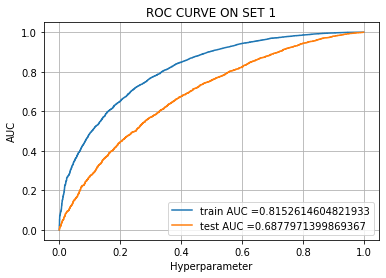

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


clf_1_a.fit(X_tr_1,y_train) #Fitting the Train Data again with best hyper parameters
y_train_pred= clf_1_a.predict_proba(X_tr_1)[:,1] #Predicting Probabilities of Class Labels of Train data
y_test_pred= clf_1_a.predict_proba(X_te_1)[:,1] #Predicting Probabilities of Class Labels of Test data
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) #Calculating FPR, TPR and Threshold on Train Data
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred) #Calculating FPR, TPR and Threshold on Test Data

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVE ON SET 1")
plt.grid()
plt.show()


#### OBSERVATION

* The **Train AUC Score= 0.815** and **Test AUC Score= 0.687** after fitting the Train Data with best Hyper Parameters

##### CONFUSION MATRIX WITH BEST THRESHOLD ON SET 1

In [30]:
#Best Threshold Value that will give the least TPR(1-FPR)
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of TPR*(1-FPR)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [31]:
#CONSUFION MATRIX USING BEST THRESHOLD
best_t_1 = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
c=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t_1))
print(c)
print("-"*100)
print("Test confusion matrix")
d= confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t_1))
print(d)
print("="*100)

The maximum value of TPR*(1-FPR) 0.5400998318975361 for threshold 0.825
Train confusion matrix
[[ 2649   893]
 [ 5531 14377]]
----------------------------------------------------------------------------------------------------
Test confusion matrix
[[1073  756]
 [3066 6655]]


##### HEATMAP OF CONFUSION MATRIX






HeatMap of Train  Confusion Matrix


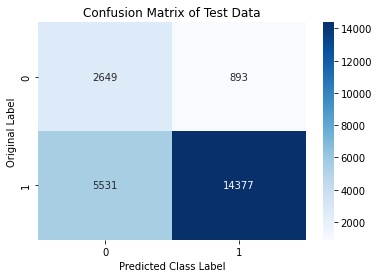

----------------------------------------------------------------------------------------------------
HeatMap of Test  Confusion Matrix


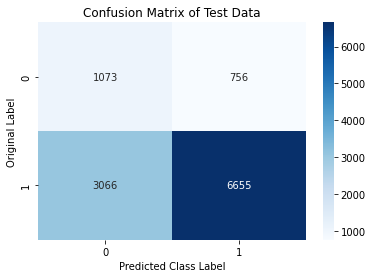

----------------------------------------------------------------------------------------------------


In [32]:
import seaborn as sns
print('HeatMap of Train  Confusion Matrix')
sns.heatmap(data=c, annot=True,cmap='Blues',fmt='d')
plt.title("Confusion Matrix of Test Data")
plt.xlabel("Predicted Class Label")
plt.ylabel("Original Label")
plt.show()
print('-'*100)

print('HeatMap of Test  Confusion Matrix')
sns.heatmap(data=d, annot=True,cmap='Blues',fmt='d')
plt.title("Confusion Matrix of Test Data")
plt.xlabel("Predicted Class Label")
plt.ylabel("Original Label")
plt.show()
print('-'*100)

#### OBSERVATION

Hence the Confusion Matrix has been printed with the **Best Threshold Value= 0.825** for the maximum value of TPR(1-FPR)=0.540

### SET 2

In [33]:
#Fitting XGBoostClassifier on Train Data of SET 2
hp_1 = {'max_depth':[1, 2, 3, 5], 'learning_rate':[0.1],'n_estimators':[5,10,15,30]}
from sklearn.model_selection import GridSearchCV
clf_b = XGBClassifier(booster='gbtree', subsample=1, colsample_bytree=1, colsample_bylevel=1, base_score=0.5, random_state=0)
clf_2 = GridSearchCV(clf, param_grid=hp, scoring="roc_auc", cv=3,n_jobs=-1, return_train_score=True)
clf_2.fit(X_tr_2,y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [1, 2, 3, 5],
                         'n_estimators': [5, 10, 15, 30]},
             return_train_score=True, scoring='roc_auc')

Best HyperParameters

In [34]:
print("Best Parameters= ",clf_2.best_params_)
print("_"*100)
print("Best AUC Score= ",clf_2.best_score_)
print("_"*100)

Best Parameters=  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}
____________________________________________________________________________________________________
Best AUC Score=  0.693352119288762
____________________________________________________________________________________________________


##### 3D Scatter Plot

In [42]:
print("TFIDF Train AUC")
train_auc_list_2=clf_2.cv_results_['mean_train_score']
print(train_auc_list_2)
print("TFIDF CV AUC")
cv_auc_list_2=clf_2.cv_results_['mean_test_score']
print(cv_auc_list_2)
print("TFIDF Max Depth")
max_depth_2=clf_2.cv_results_['param_max_depth']
print(max_depth_2)

trace3 = go.Scatter3d(x=np.arange(1,31),y=max_depth_2,z=train_auc_list_2, name = 'Train AUC')
trace4 = go.Scatter3d(x=np.arange(1,31),y=max_depth_2,z=cv_auc_list_2, name = 'CV AUC')
data = [trace3, trace4]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')
plt.show()

TFIDF Train AUC
[0.61495666 0.63637957 0.64818654 0.66953587 0.65079895 0.67122487
 0.68362447 0.71425922 0.68279291 0.70483378 0.72163368 0.75534964
 0.75526887 0.79241339 0.81776734 0.86788089]
TFIDF CV AUC
[0.60734992 0.62563545 0.63288979 0.65153599 0.62756512 0.6430476
 0.6529717  0.67339052 0.64069579 0.65339607 0.66466097 0.68351136
 0.64845477 0.66482649 0.67345399 0.69335212]
TFIDF Max Depth
[1 1 1 1 2 2 2 2 3 3 3 3 5 5 5 5]


Fitting the Test Data with Best Parameters


In [35]:
clf_2_a = XGBClassifier(max_depth= 5, learning_rate=0.1, n_estimators=30, booster='gbtree', subsample=1, colsample_bytree=1, colsample_bylevel=1, base_score=0.5,random_state=0)
clf_2_a.fit(X_te_2,y_test)

XGBClassifier(max_depth=5, n_estimators=30)

Plotting ROC Curve (SET 2)

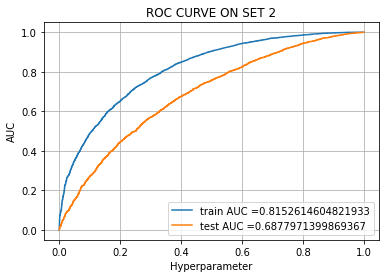

In [36]:
clf_2_a.fit(X_tr_1,y_train) #Fitting the Train Data again with best hyper parameters
y_train_pred_2= clf_2_a.predict_proba(X_tr_1)[:,1] #Predicting Probabilities of Class Labels of Train data
y_test_pred_2= clf_2_a.predict_proba(X_te_1)[:,1] #Predicting Probabilities of Class Labels of Test data
train_fpr_2, train_tpr_2, tr_thresholds_2 = roc_curve(y_train, y_train_pred_2) #Calculating FPR, TPR and Threshold on Train Data
test_fpr_2, test_tpr_2, te_thresholds_2 = roc_curve(y_test, y_test_pred_2) #Calculating FPR, TPR and Threshold on Test Data

plt.plot(train_fpr_2, train_tpr_2, label="train AUC ="+str(auc(train_fpr_2, train_tpr_2)))
plt.plot(test_fpr_2, test_tpr_2, label="test AUC ="+str(auc(test_fpr_2, test_tpr_2)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVE ON SET 2")
plt.grid()
plt.show()

#### OBSERVATION

* The **Train AUC Score= 0.815** and **Test AUC Score= 0.687** after fitting the Train Data with best Hyper Parameters for SET 2.

* There is no difference between the AUC Scores of SET 1 and SET 2.

##### CONFUSION MATRIX WITH BEST THRESHOLD ON SET 2

In [37]:
best_t_2 = find_best_threshold(tr_thresholds_2, train_fpr_2, train_tpr_2)
print("Train confusion matrix")
c2=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t_2))
print(c2)
print("-"*100)
print("Test confusion matrix")
d2= confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t_2))
print(d2)
print("="*100)

The maximum value of TPR*(1-FPR) 0.5400998318975361 for threshold 0.825
Train confusion matrix
[[ 2649   893]
 [ 5531 14377]]
----------------------------------------------------------------------------------------------------
Test confusion matrix
[[1073  756]
 [3066 6655]]


HeatMap of Train  Confusion Matrix


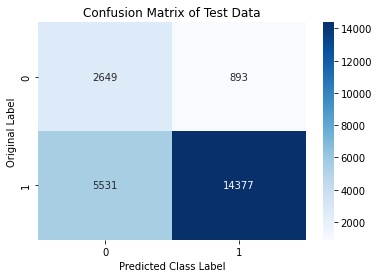

----------------------------------------------------------------------------------------------------
HeatMap of Test  Confusion Matrix


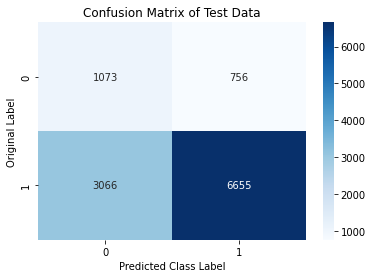

----------------------------------------------------------------------------------------------------


In [39]:
print('HeatMap of Train  Confusion Matrix')
sns.heatmap(data=c2, annot=True,cmap='Blues',fmt='d')
plt.title("Confusion Matrix of Test Data")
plt.xlabel("Predicted Class Label")
plt.ylabel("Original Label")
plt.show()
print('-'*100)

print('HeatMap of Test  Confusion Matrix')
sns.heatmap(data=d2, annot=True,cmap='Blues',fmt='d')
plt.title("Confusion Matrix of Test Data")
plt.xlabel("Predicted Class Label")
plt.ylabel("Original Label")
plt.show()
print('-'*100)


#### OBSERVATION

Hence the Confusion Matrix has been printed with the **Best Threshold Value= 0.825** for the maximum value of TPR(1-FPR)=0.540

<h1>2. SUMMARY</h1>


In [45]:
#Summary in a table

from prettytable import PrettyTable
table=PrettyTable(['Vectorizer','Model','Hyperparameter 1','Hyperparameter 2','Hyperparamater 3','Train AUC','TestAUC'])
table.add_row(['TFIDF','GBDT(XGBoost)','n_estimators=30','Max_Depth=5' ,'Learning Rate=0.1',0.815,0.687 ])
table.add_row(['TFIDF-W2V','GBDT(XGBoost)','n_estimators=30','Max_Depth=5' ,'Learning Rate=0.1',0.815,0.687])
print(table)

+------------+---------------+------------------+------------------+-------------------+-----------+---------+
| Vectorizer |     Model     | Hyperparameter 1 | Hyperparameter 2 |  Hyperparamater 3 | Train AUC | TestAUC |
+------------+---------------+------------------+------------------+-------------------+-----------+---------+
|   TFIDF    | GBDT(XGBoost) | n_estimators=30  |   Max_Depth=5    | Learning Rate=0.1 |   0.815   |  0.687  |
| TFIDF-W2V  | GBDT(XGBoost) | n_estimators=30  |   Max_Depth=5    | Learning Rate=0.1 |   0.815   |  0.687  |
+------------+---------------+------------------+------------------+-------------------+-----------+---------+


##3. CONCLUSION


* Out of all the Models we have fit on Donors Chose Dataset as of now, we see that GBDT(XGBoost) has given us the highest Train AUC Score of **0.815**, and also the highest Test AUC Score of **0.687**.

* This might be due to chosing **Response Coding of Categorical Features**, which gives us smaller probability vectors, over One Hot Encoding which gives us Binary Vectors which may be very large. Also the number of features in One Hot Encoding is significantly larger than response coding. Since Decision Trees perform better with lesser number of features, Response Coding has given us better results.